<a href="https://colab.research.google.com/github/wentao0420/IANNwTF_Group40/blob/main/Changing_Parameters_Homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Changing Parameters**

---

1. Changed learning rate (from 0.01 to 0.1)
2. Tried other optimizers (AdaGrad, RMSProp, SGD with momentum), but Adam showed the best results, so we stick to Adam
3. Added 3 conv layers (convlayer5, convlayer6, convlayer7)
4. Changed number of filter (convlayer1-3: from 24 to 256; convlayer4-7: from 48 to 512)

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import datetime as datetime
import tqdm

In [17]:
(train_ds, test_ds), ds_info = tfds.load ('cifar10', split =['train', 'test'], as_supervised = True, with_info = True)

In [18]:
def preprocess(ds):
    # image should be float
    ds = ds.map(lambda x, t: (tf.cast(x, tf.float32), t))
    # image vector will here have values between -1 and 1
    ds = ds.map(lambda x,t: ((x/128.)-1., t))
    # target vector is converted into one-hot vector
    ds = ds.map(lambda x, t: (x, tf.one_hot(t, depth=10))) 
    # cache
    ds = ds.cache()
    # shuffle, batch, prefetch
    ds = ds.shuffle(1000)
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE) 

    return ds    

train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

In [38]:
class BasicConv(tf.keras.Model):
    def __init__(self):
        super(BasicConv, self).__init__()

        self.metrics_list = [tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                             tf.keras.metrics.Mean(name="loss")]
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_function = tf.keras.losses.CategoricalCrossentropy()

        self.convlayer1 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu') 
        self.convlayer2 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu') 
        self.convlayer3 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu') 
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer4 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu') 
        self.convlayer5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')
        self.convlayer6 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')
        self.convlayer7 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        
        self.out = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function
    def train_step(self, data):
        img, label = data

        with tf.GradientTape() as tape:
            prediction = self(img, training=True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        img, label = data

        prediction = self(img, training=False)
        loss = self.loss_function(label, prediction)

        # update the state of the metrics according to loss
        self.metrics[0].update_state(label, prediction)
        self.metrics[1].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

In [39]:
def create_summary_writers(config_name):
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    
    return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

In [41]:
# initialize lists for later visualiztion
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# initialize epochs and learning rate
epochs = 15
learning_rate = 0.1

# initialize model
model = BasicConv()

In [42]:
def training():
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch}, optimizer: {model.optimizer}")

        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)

            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        for (key, value) in metrics.items():
            if key == "loss":
                train_losses.append(value.numpy())
            elif key == "accuracy":
                train_accuracies.append(value.numpy())

        # reset metric object
        model.reset_metrics()

        # evaluate on validation data
        for data in test_ds:
            metrics = model.test_step(data)

        # log validation metrics
        with val_summary_writer.as_default():
            for metric in model.metrics:
                tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                val_losses.append(value.numpy())
            elif key == "accuracy":
                val_accuracies.append(value.numpy())

        # reset all metrics
        model.reset_metrics()

In [43]:
training()

Epoch: 0, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:40<00:00, 38.75it/s]


['train_accuracy: 0.9130539894104004', 'train_loss: 1.4789992570877075']
['val_accuracy: 0.9283599853515625', 'val_loss: 1.17416512966156']
Epoch: 1, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.91it/s]


['train_accuracy: 0.9371659755706787', 'train_loss: 0.9921972751617432']
['val_accuracy: 0.9441499710083008', 'val_loss: 0.8611710667610168']
Epoch: 2, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:38<00:00, 40.20it/s]


['train_accuracy: 0.9499660134315491', 'train_loss: 0.7764374613761902']
['val_accuracy: 0.9477800130844116', 'val_loss: 0.804219663143158']
Epoch: 3, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 40.05it/s]


['train_accuracy: 0.9578740000724792', 'train_loss: 0.6478350162506104']
['val_accuracy: 0.9521899819374084', 'val_loss: 0.7430160045623779']
Epoch: 4, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.66it/s]


['train_accuracy: 0.964434027671814', 'train_loss: 0.5417011380195618']
['val_accuracy: 0.9585000276565552', 'val_loss: 0.6398484110832214']
Epoch: 5, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.43it/s]


['train_accuracy: 0.9698820114135742', 'train_loss: 0.4546303451061249']
['val_accuracy: 0.9634199738502502', 'val_loss: 0.5681224465370178']
Epoch: 6, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.53it/s]


['train_accuracy: 0.9747719764709473', 'train_loss: 0.3749327063560486']
['val_accuracy: 0.9617999792098999', 'val_loss: 0.6222088932991028']
Epoch: 7, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.49it/s]


['train_accuracy: 0.9795420169830322', 'train_loss: 0.3015784025192261']
['val_accuracy: 0.9640399813652039', 'val_loss: 0.6164453029632568']
Epoch: 8, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.49it/s]


['train_accuracy: 0.9836699962615967', 'train_loss: 0.23872241377830505']
['val_accuracy: 0.9627500176429749', 'val_loss: 0.6680644154548645']
Epoch: 9, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.60it/s]


['train_accuracy: 0.987388014793396', 'train_loss: 0.18086373805999756']
['val_accuracy: 0.9634400010108948', 'val_loss: 0.7414306998252869']
Epoch: 10, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:40<00:00, 38.18it/s]


['train_accuracy: 0.9899579882621765', 'train_loss: 0.14420977234840393']
['val_accuracy: 0.9629700183868408', 'val_loss: 0.7534069418907166']
Epoch: 11, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.60it/s]


['train_accuracy: 0.9918980002403259', 'train_loss: 0.11731764674186707']
['val_accuracy: 0.9640799760818481', 'val_loss: 0.8116056323051453']
Epoch: 12, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.54it/s]


['train_accuracy: 0.9930059909820557', 'train_loss: 0.09884185343980789']
['val_accuracy: 0.9624599814414978', 'val_loss: 0.8616166114807129']
Epoch: 13, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.44it/s]


['train_accuracy: 0.9942399859428406', 'train_loss: 0.08259576559066772']
['val_accuracy: 0.9616199731826782', 'val_loss: 0.9398605823516846']
Epoch: 14, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x7fadb2bdbe80>


100%|██████████| 1563/1563 [00:39<00:00, 39.54it/s]


['train_accuracy: 0.9946380257606506', 'train_loss: 0.07948978990316391']
['val_accuracy: 0.9634400010108948', 'val_loss: 0.9049245119094849']


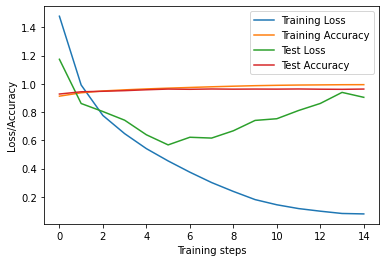

In [44]:
fig = plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(train_accuracies)
line3, = plt.plot(val_losses)
line4, = plt.plot(val_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3, line4),("Training Loss","Training Accuracy","Test Loss","Test Accuracy"))
plt.show()